# SWIR - Tumbarumba

A timeseries of __SWIR__ change at the tumbarumba study site from __Nov 2019 - April 2021__ using __Sentinal 2 Imagery__

### Packages

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import os

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.temporal import xr_phenology


In [2]:
def fast_completion(da):
    """
    gap-fill a timeseries
    """
    if len(da.shape) == 1:
        raise Exception("'fast_completion' does not currently operate on 1D timeseries")
    # complete the timeseries (remove NaNs)
    # grab coords etc
    x, y, time, attrs = da.x, da.y, da.time, da.attrs

    # reshape to satisfy function
    da = da.transpose("y", "x", "time").values

    mask = np.isnan(da)
    idx = np.where(~mask, np.arange(mask.shape[-1]), 0)
    np.maximum.accumulate(idx, axis=-1, out=idx)
    i, j = np.meshgrid(np.arange(idx.shape[0]),
                       np.arange(idx.shape[1]),
                       indexing="ij")
    dat = da[i[:, :, np.newaxis], j[:, :, np.newaxis], idx]
    if np.isnan(np.sum(dat[:, :, 0])):
        fill = np.nanmean(dat, axis=-1)
        for t in range(dat.shape[-1]):
            mask = np.isnan(dat[:, :, t])
            if mask.any():
                dat[mask, t] = fill[mask]
            else:
                break

    #stack back into dataarray
    dat = xr.DataArray(
                dat,
                attrs=attrs,
                coords={
                    "x": x,
                    "y": y,
                    "time": time
                },
                dims=["y", "x", "time"],
            )

    return dat

In [3]:
dc = datacube.Datacube(app='Calculating_band_indices') ## Connects to the datacube

### Input Analysis Paramaters

In [4]:
# Define area of interest
lat = -35.655958
lon = 148.151751
lon_buffer = 0.005
lat_buffer = 0.005

# Set the range of dates for the analysis
# Set the range of dates for the analysis
#time_range = ('2018-01', '2018-06')
time_range = ('2016-01', '2021-05')

In [5]:
# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

### Selected location for SWIR Analysis

In [6]:
# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)
display_map(x=lon_range, y=lat_range)

### Cloud masking requirements
Aim is to get imagery that are a min of 75% cloud free

In [7]:
# Create a reusable query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_nir_1', 'nbart_swir_2', 'nbart_swir_3'],
    'resolution': (-20, 20),
    'output_crs': 'epsg:3577',
    'group_by': 'solar_day'
}

# Load available data from Landsat 8
ds = load_ard(
    dc=dc,
    products=['s2a_ard_granule', 's2b_ard_granule'],
    min_gooddata=0.75,
    **query,
)

print(ds)

Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Counting good quality pixels for each time step


CPLReleaseMutex: Error = 1 (Operation not permitted)


Filtering to 271 out of 634 time steps with at least 75.0% good quality pixels
Applying pixel quality/cloud mask
Loading 271 time steps
<xarray.Dataset>
Dimensions:       (time: 271, y: 62, x: 52)
Coordinates:
  * time          (time) datetime64[ns] 2016-01-01T00:09:15.704000 ... 2021-0...
  * y             (y) float64 -3.987e+06 -3.987e+06 ... -3.988e+06 -3.988e+06
  * x             (x) float64 1.457e+06 1.457e+06 ... 1.458e+06 1.458e+06
    spatial_ref   int32 3577
Data variables:
    nbart_red     (time, y, x) float32 572.0 541.0 540.0 ... 365.0 432.0 331.0
    nbart_green   (time, y, x) float32 564.0 553.0 528.0 ... 244.0 309.0 236.0
    nbart_blue    (time, y, x) float32 496.0 466.0 482.0 ... 104.0 178.0 101.0
    nbart_nir_1   (time, y, x) float32 2.23e+03 2.014e+03 ... 1.637e+03
    nbart_swir_2  (time, y, x) float32 1.03e+03 1.056e+03 ... 1.437e+03
    nbart_swir_3  (time, y, x) float32 532.0 556.0 552.0 ... 731.0 875.0 924.0
Attributes:
    crs:           epsg:3577
    grid_ma

In [8]:
# Define NIR band from the datastore
SWIR = ds.nbart_swir_2

### Plot SWIR over the timeseries

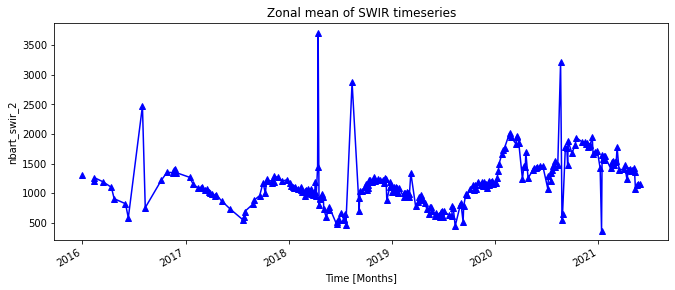

In [9]:
SWIR.mean(['x', 'y']).plot.line('b-^', figsize=(11, 4))
plt.title('Zonal mean of SWIR timeseries')
plt.xlabel('Time [Months]');

/env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


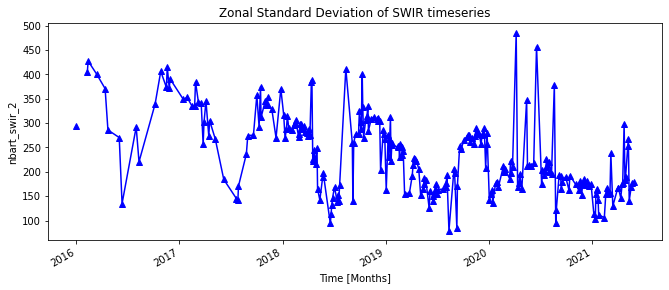

In [10]:
SWIR.std(['x', 'y']).plot.line('b-^', figsize=(11, 4))
plt.title('Zonal Standard Deviation of SWIR timeseries')
plt.xlabel('Time [Months]');

__Smooth the timeseries to remove incoonsistencies__

In [11]:
resample_period='2W'
window=4

veg_smooth=SWIR.resample(time=resample_period).median().rolling(time=window, min_periods=1).mean()

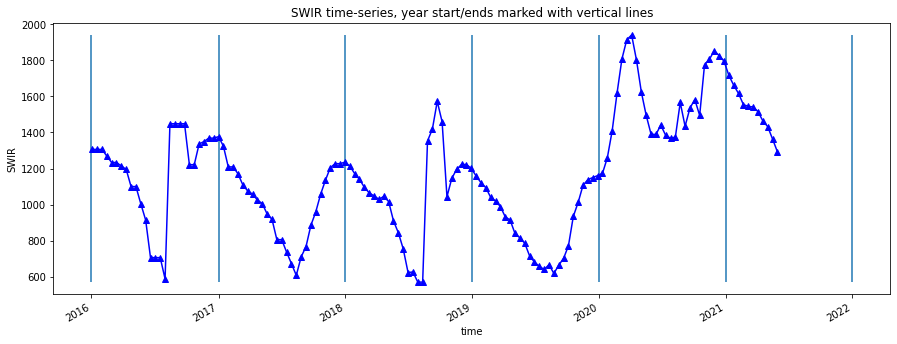

In [12]:
veg_smooth_1D = veg_smooth.mean(['x', 'y'])
veg_smooth_1D.plot.line('b-^', figsize=(15,5))
_max=veg_smooth_1D.max()
_min=veg_smooth_1D.min()
plt.vlines(np.datetime64('2016-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2017-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2018-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2019-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2020-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2021-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2022-01-01'), ymin=_min, ymax=_max)
plt.title('SWIR time-series, year start/ends marked with vertical lines')
plt.ylabel('SWIR');

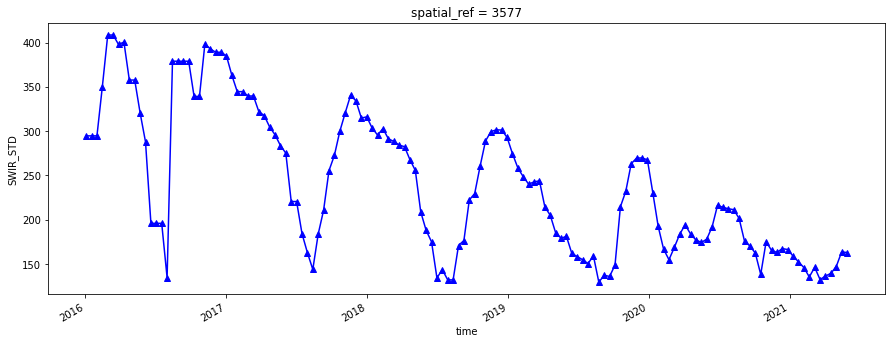

In [13]:
veg_smooth_1D_STD = veg_smooth.std(['x', 'y'])
veg_smooth_1D_STD.plot.line('b-^', figsize=(15,5))
_max=veg_smooth_1D_STD.max()
_min=veg_smooth_1D_STD.min()
plt.ylabel('SWIR_STD');

## SWIR Export

Modify time for export

In [14]:
veg_smooth_time = veg_smooth.time
arr = np.array(veg_smooth_time, dtype='datetime64[s]')

Exporting EVI

In [14]:
df = pd.DataFrame(veg_smooth_1D, columns = ['SWIR'])

In [15]:
df['time'] = arr

In [16]:
from numpy import savetxt
df.to_csv('SWIR_smoothed_mean.csv')

In [15]:
df2 = pd.DataFrame(veg_smooth_1D_STD, columns = ['SWIR_STD'])

In [16]:
df2['time'] = arr

In [17]:
from numpy import savetxt
df2.to_csv('SWIR_smoothed_std.csv')

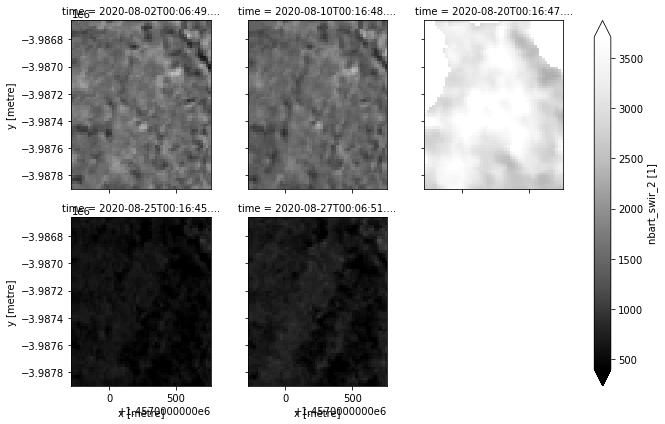

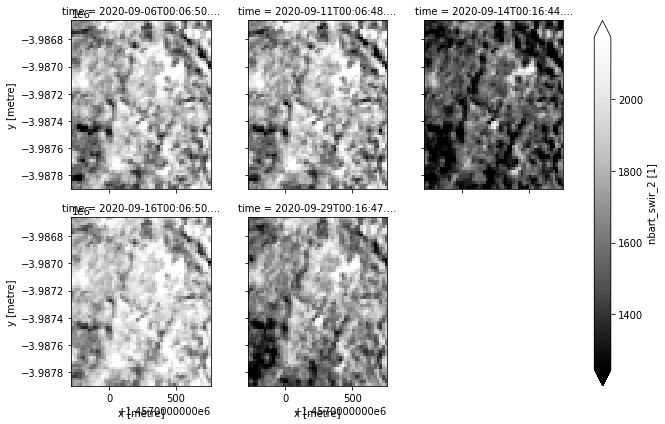

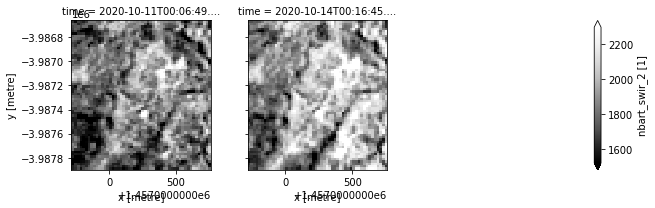

In [12]:
# print a selection of the imagery to check for consistency
timestep1 = ds.nbart_swir_2.sel(time = '2020-08')
timestep2 = ds.nbart_swir_2.sel(time = '2020-09')
timestep3 = ds.nbart_swir_2.sel(time = '2020-10')
#print(timestep)
#show(timestep, col = 'time', col_wrap=3) # Modify index dep on images selected above
timestep1.plot(cmap = "Greys_r", robust = True, col = 'time', col_wrap=3)
timestep2.plot(cmap = "Greys_r", robust = True, col = 'time', col_wrap=3)
timestep3.plot(cmap = "Greys_r", robust = True, col = 'time', col_wrap=3)